In [1]:
using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz


In [2]:
# Functions for graphing typed Petri nets
colors = ["red","turquoise", "blue", "yellow", "green"]

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(p, s) = ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>"#9ACEEB"))

def_auxiliaryV(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:F](incident(p,v,:fv)...)]))


def_auxiliaryV(colors = colors)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[incident(p,v,:fv)...]))



def_sumV(p, sv) = ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>"cornflowerblue", 
                                       :style=>"filled"))  



def_sumV (generic function with 1 method)

In [3]:
def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
     colorType = colors[typed_petri[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors)=
  (p, us, ds, v, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

Graph_typed(typed_StockFlow::ACSetTransformation, colors = colors) = Graph(dom(typed_StockFlow),
    make_stock = def_stock, make_auxiliaryV=def_auxiliaryV(typed_StockFlow, colors), make_sumV=def_sumV, 
    make_flow_V=def_flow_V(typed_StockFlow, colors), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors)
)

Graph_typed (generic function with 2 methods)

In [4]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
diabetes_type=StockAndFlowStructure(
    (:Pop=>((:progress, :diagnosis_strata),(:deaths, :progress, :diagnosis_strata),(:v_deaths, :v_progress, :v_diagnosis_strata),:N)),
    (:deaths=>:v_deaths, :progress=>:v_progress, :diagnosis_strata=>:v_diagnosis_strata),
    (:N=>:SVV_NONE)
)

StockAndFlowStructure with elements S = 1:1, SV = 1:1, LS = 1:1, F = 1:3, I = 1:2, O = 1:3, V = 1:3, LV = 1:3, LSV = 1:0
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   Pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  1 │           deaths │
│ 2 │  2 │         progress │
│ 3 │  3 │ diagnosis_strata │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬────────────────────┐
│ V │              vname │
├───┼────────────────────┤
│ 1 │           v_deaths │
│ 2 │         v_progress │
│ 3 │ v_diagnosis_strata │
└───┴────────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   1 │   2 │
│  3 │   1 │   3 │
└────┴─────┴─────┘

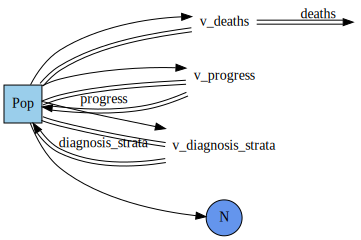

In [5]:
Graph(diabetes_type)

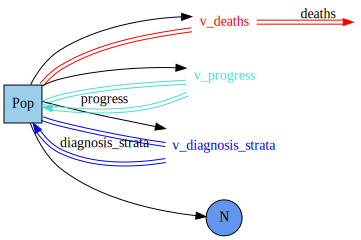

In [6]:
Graph_typed(id(diabetes_type))

In [7]:
# define the index name of each part

In [8]:
s, = parts(diabetes_type, :S)
sv, = parts(diabetes_type, :SV)
lsn, = parts(diabetes_type, :LS)
f_deaths, f_progress, f_strata = parts(diabetes_type, :F)
i_progress, i_strata = parts(diabetes_type, :I)
o_deaths, o_progress, o_strata = parts(diabetes_type, :O)
v_deaths, v_progress, v_strata = parts(diabetes_type, :V)
lv_deaths, lv_progress, lv_strata = parts(diabetes_type, :LV)

1:3

In [9]:
# remove names to allow for the loose ACSet transform to be natural
diabetes_type = map(diabetes_type, Name=name->nothing);

In [10]:
# define the strata model

In [11]:
diagnosis_strata=StockAndFlowStructure(
    (:U=>(:progress_U,(:deaths_U, :progress_U, :strata),(:v_deaths_U, :v_progress_U, :v_strata),:N),
        :D=>((:progress_D, :strata),(:progress_D, :deaths_D),(:v_progress_D, :v_deaths_D),:N)),
    (:deaths_U=>:v_deaths_U, :progress_U=>:v_progress_U, :deaths_D=>:v_deaths_D, :progress_D=>:v_progress_D,:strata=>:v_strata),
    (:N=>:SVV_NONE)
)

StockAndFlowStructure with elements S = 1:2, SV = 1:1, LS = 1:2, F = 1:5, I = 1:3, O = 1:5, V = 1:5, LV = 1:5, LSV = 1:0
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     U │
│ 2 │     D │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  1 │   deaths_U │
│ 2 │  2 │ progress_U │
│ 3 │  3 │   deaths_D │
│ 4 │  4 │ progress_D │
│ 5 │  5 │     strata │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   4 │  2 │
│ 3 │   5 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   5 │  1 │
│ 4 │   4 │  2 │
│ 5 │   3 │  2 │
└───┴─────┴────┘
┌───┬──────────────┐
│ V │        vname │
├───┼──────────────┤
│ 1 │   v_deaths_U │
│ 2 │ v_progress_U │
│ 3 │   v_deaths_D │
│ 4 │ v_progress_D │
│ 5 │     v_strata │
└───┴──────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   1 │   2 │
│  3 │   1 │   5 │
│  4 │   2 │   4 │
│  5 │   2 │   3 │
└────┴─────┴─────┘

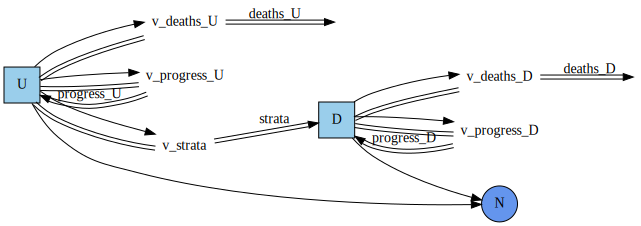

In [12]:
Graph(diagnosis_strata)

In [13]:
# i_progress, i_strata
typed_diagnosis_strata=ACSetTransformation(diagnosis_strata, diabetes_type,
  S = [s, s],
  SV = [sv],
  LS = [lsn, lsn],
  F = [f_deaths, f_progress, f_deaths, f_progress, f_strata],
  I = [i_progress, i_progress, i_strata],
  O = [o_deaths, o_progress, o_strata, o_progress, o_deaths],
  V = [v_deaths, v_progress, v_deaths, v_progress, v_strata],
  LV = [lv_deaths, lv_progress, lv_strata, lv_progress, lv_deaths],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
)


ACSetTransformation((S = FinFunction([1, 1], 2, 1), SV = FinFunction([1], 1, 1), LS = FinFunction([1, 1], 2, 1), F = FinFunction([1, 2, 1, 2, 3], 5, 3), I = FinFunction([1, 1, 2], 3, 2), O = FinFunction([1, 2, 3, 2, 1], 5, 3), V = FinFunction([1, 2, 1, 2, 3], 5, 3), LV = FinFunction([1, 2, 3, 2, 1], 5, 3), LSV = FinFunction(1:0, 0, 0), Name = SetFunction(#15, TypeSet(Symbol), TypeSet(Nothing))), StockAndFlowStructureUntyped {S = 2, SV = 1, LS = 2, F = 5, I = 3, O = 5, V = 5, LV = 5, LSV = 0}, StockAndFlowStructureUntyped {S = 1, SV = 1, LS = 1, F = 3, I = 2, O = 3, V = 3, LV = 3, LSV = 0})

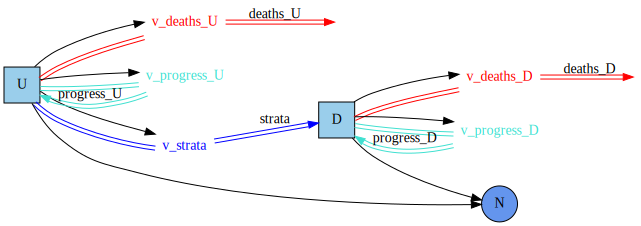

In [14]:
@assert is_natural(typed_diagnosis_strata)
Graph_typed(typed_diagnosis_strata)

In [15]:
is_natural(typed_diagnosis_strata)

true

In [23]:
# define the progress model

In [26]:
diabetes_progress=StockAndFlowStructure(
    (:PreDiabetic=>(:diagnosePreDiabetic,(:DevelopingPreDiabetic, :deathsPreDiabetic, :diagnosePreDiabetic),(:v_DevelopingPreDiabetic, :v_deathsPreDiabetic, :v_diagnosePreDiabetic),:N),
        :DiabeticWtComp=>((:DevelopingPreDiabetic, :diagnoseDiabeticWtComp),(:DevelopingEarly, :deathsDiabeticWtComp, :diagnoseDiabeticWtComp),(:v_DevelopingEarly, :v_deathsDiabeticWtComp, :v_diagnoseDiabeticWtComp),:N),
        :DiabeticEarly=>((:DevelopingEarly, :diagnoseDiabeticEarly),(:DevelopingLate, :deathsDiabeticEarly, :diagnoseDiabeticEarly),(:v_DevelopingLate, :v_deathsDiabeticEarly, :v_diagnoseDiabeticEarly),:N),
        :DiabeticLate=>((:DevelopingLate,:diagnoseDiabeticLate),(:deathsDiabeticLate,:diagnoseDiabeticLate),(:v_deathsDiabeticLate,:v_diagnoseDiabeticLate),:N)),
    (:diagnosePreDiabetic=>:v_diagnosePreDiabetic, :diagnoseDiabeticWtComp=>:v_diagnoseDiabeticWtComp, :diagnoseDiabeticEarly=>:v_diagnoseDiabeticEarly, :diagnoseDiabeticLate=>:v_diagnoseDiabeticLate,
        :deathsPreDiabetic=>:v_deathsPreDiabetic, :deathsDiabeticWtComp=>:v_deathsDiabeticWtComp, :deathsDiabeticEarly=>:v_deathsDiabeticEarly, :deathsDiabeticLate=>:v_deathsDiabeticLate,
        :DevelopingPreDiabetic=>:v_DevelopingPreDiabetic, :DevelopingEarly=>:v_DevelopingEarly, :DevelopingLate=>:v_DevelopingLate),
    (:N=>:SVV_NONE)
)

StockAndFlowStructure with elements S = 1:4, SV = 1:1, LS = 1:4, F = 1:11, I = 1:7, O = 1:11, V = 1:11, LV = 1:11, LSV = 1:0
┌───┬────────────────┐
│ S │          sname │
├───┼────────────────┤
│ 1 │    PreDiabetic │
│ 2 │ DiabeticWtComp │
│ 3 │  DiabeticEarly │
│ 4 │   DiabeticLate │
└───┴────────────────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
└────┴─────┴──────┘
┌────┬────┬────────────────────────┐
│  F │ fv │                  fname │
├────┼────┼────────────────────────┤
│  1 │  1 │    diagnosePreDiabetic │
│  2 │  2 │ diagnoseDiabeticWtComp │
│  3 │  3 │  diagnoseDiabeticEarly │
│  4 │  4 │   diagnoseDiabeticLate │
│  5 │  5 │      deathsPreDiabetic │
│  6 │  6 │   deathsDiabeticWtComp │
│  7 │  7 │    deathsDiabeticEarly │
│  8 │  8 │     deathsDiabeticLate │
│  9 │  9 │  DevelopingPreDiabetic │
│ 10 │ 10 │        DevelopingEarly │
│ 11 │ 11 │         DevelopingLate │
└────┴────┴────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   9 │  2 │
│ 3 │   2 │  2 │
│ 4 │  10 │  3 │
│ 5 │   3 │  3 │
│ 6 │  11 │  4 │
│ 7 │   4 │  4 │
└───┴─────┴────┘
┌────┬─────┬────┐
│  O │ ofn │ os │
├────┼─────┼────┤
│  1 │   9 │  1 │
│  2 │   5 │  1 │
│  3 │   1 │  1 │
│  4 │  10 │  2 │
│  5 │   6 │  2 │
│  6 │   2 │  2 │
│  7 │  11 │  3 │
│  8 │   7 │  3 │
│  9 │   3 │  3 │
│ 10 │   8 │  4 │
│ 11 │   4 │  4 │
└────┴─────┴────┘
┌────┬──────────────────────────┐
│  V │                    vname │
├────┼──────────────────────────┤
│  1 │    v_diagnosePreDiabetic │
│  2 │ v_diagnoseDiabeticWtComp │
│  3 │  v_diagnoseDiabeticEarly │
│  4 │   v_diagnoseDiabeticLate │
│  5 │      v_deathsPreDiabetic │
│  6 │   v_deathsDiabeticWtComp │
│  7 │    v_deathsDiabeticEarly │
│  8 │     v_deathsDiabeticLate │
│  9 │  v_DevelopingPreDiabetic │
│ 10 │        v_DevelopingEarly │
│ 11 │         v_DevelopingLate │
└────┴──────────────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   9 │
│  2 │   1 │   5 │
│  3 │   1 │   1 │
│  4 │   2 │  10 │
│  5 │   2 │   6 │
│  6 │   2 │   2 │
│  7 │   3 │  11 │
│  8 │   3 │   7 │
│  9 │   3 │   3 │
│ 10 │   4 │   8 │
│ 11 │   4 │   4 │
└────┴─────┴─────┘

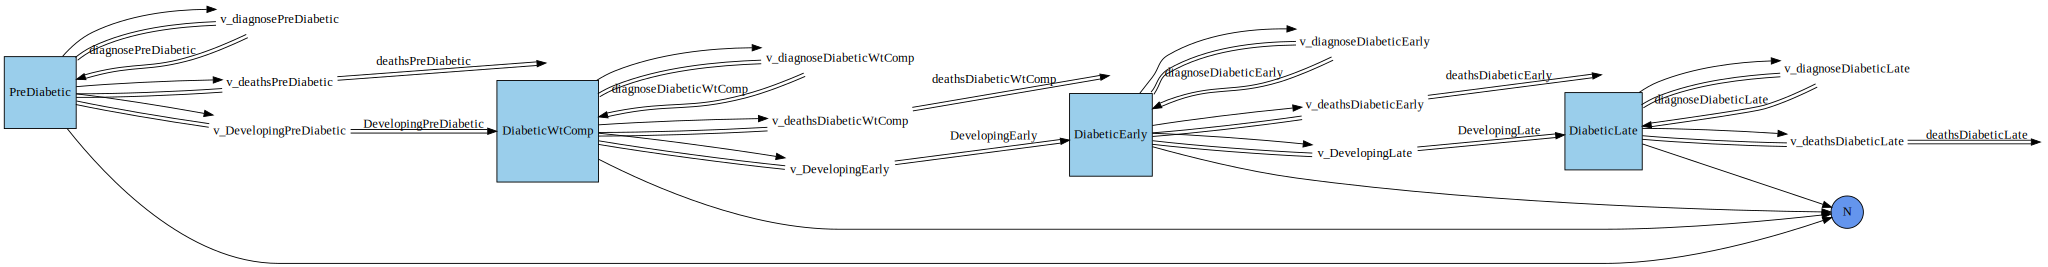

In [27]:
Graph(diabetes_progress)

In [28]:
typed_diabetes_progress=ACSetTransformation(diabetes_progress, diabetes_type,
  S = [s, s, s, s],
  SV = [sv],
  LS = [lsn, lsn, lsn, lsn],
  F = [f_strata, f_strata, f_strata, f_strata, f_deaths, f_deaths, f_deaths, f_deaths, f_progress, f_progress, f_progress],
  I = [i_strata, i_progress, i_strata, i_progress, i_strata, i_progress, i_strata],
  O = [o_progress, o_deaths, o_strata, o_progress, o_deaths, o_strata, o_progress, o_deaths, o_strata, o_deaths, o_strata],
  V = [v_strata, v_strata, v_strata, v_strata, v_deaths, v_deaths, v_deaths, v_deaths, v_progress, v_progress, v_progress],
  LV = [lv_progress, lv_deaths, lv_strata, lv_progress, lv_deaths, lv_strata, lv_progress, lv_deaths, lv_strata, lv_deaths, lv_strata],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
)

ACSetTransformation((S = FinFunction([1, 1, 1, 1], 4, 1), SV = FinFunction([1], 1, 1), LS = FinFunction([1, 1, 1, 1], 4, 1), F = FinFunction([3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2], 11, 3), I = FinFunction([2, 1, 2, 1, 2, 1, 2], 7, 2), O = FinFunction([2, 1, 3, 2, 1, 3, 2, 1, 3, 1, 3], 11, 3), V = FinFunction([3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2], 11, 3), LV = FinFunction([2, 1, 3, 2, 1, 3, 2, 1, 3, 1, 3], 11, 3), LSV = FinFunction(1:0, 0, 0), Name = SetFunction(#27, TypeSet(Symbol), TypeSet(Nothing))), StockAndFlowStructureUntyped {S = 4, SV = 1, LS = 4, F = 11, I = 7, O = 11, V = 11, LV = 11, LSV = 0}, StockAndFlowStructureUntyped {S = 1, SV = 1, LS = 1, F = 3, I = 2, O = 3, V = 3, LV = 3, LSV = 0})

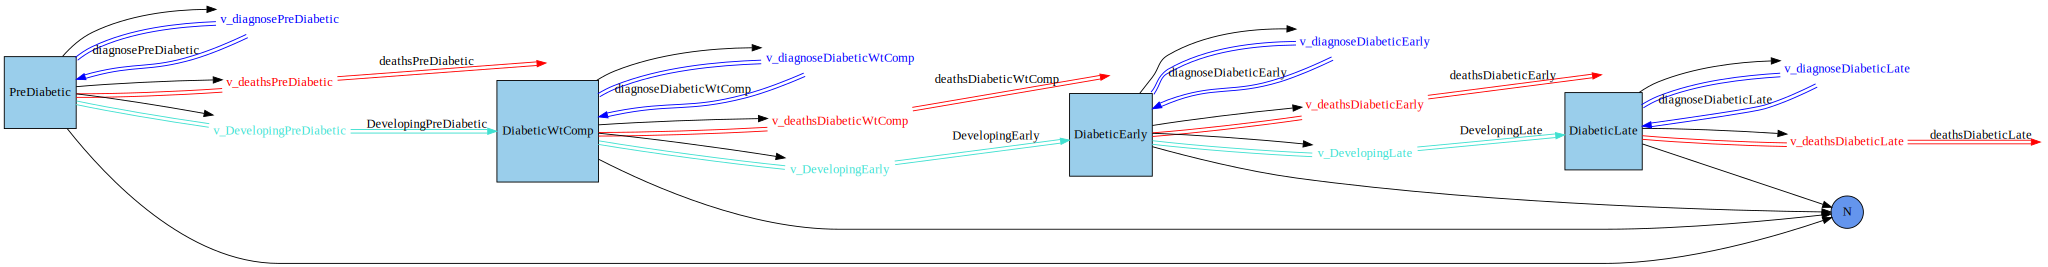

In [33]:
@assert is_natural(typed_diabetes_progress)
Graph_typed(typed_diabetes_progress)

In [44]:
strat_model = pullback(typed_diagnosis_strata, typed_diabetes_progress)
apex(strat_model)

S,sname
1,"(:U, :PreDiabetic)"
2,"(:D, :PreDiabetic)"
3,"(:U, :DiabeticWtComp)"
4,"(:D, :DiabeticWtComp)"
5,"(:U, :DiabeticEarly)"
6,"(:D, :DiabeticEarly)"
7,"(:U, :DiabeticLate)"
8,"(:D, :DiabeticLate)"
SV,svname
1,"(:N, :N)"


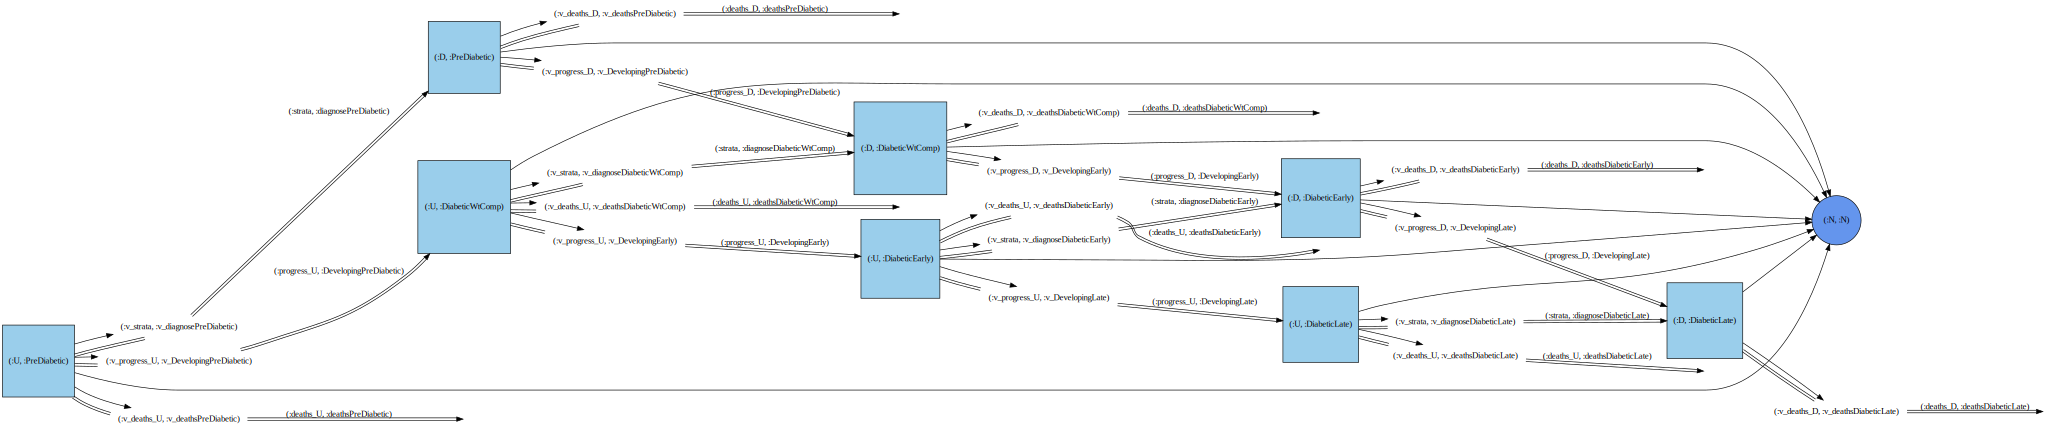

In [43]:
Graph(apex(strat_model))

In [45]:
# Plot the typed stock and flow diagram

In [34]:
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))

typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1);

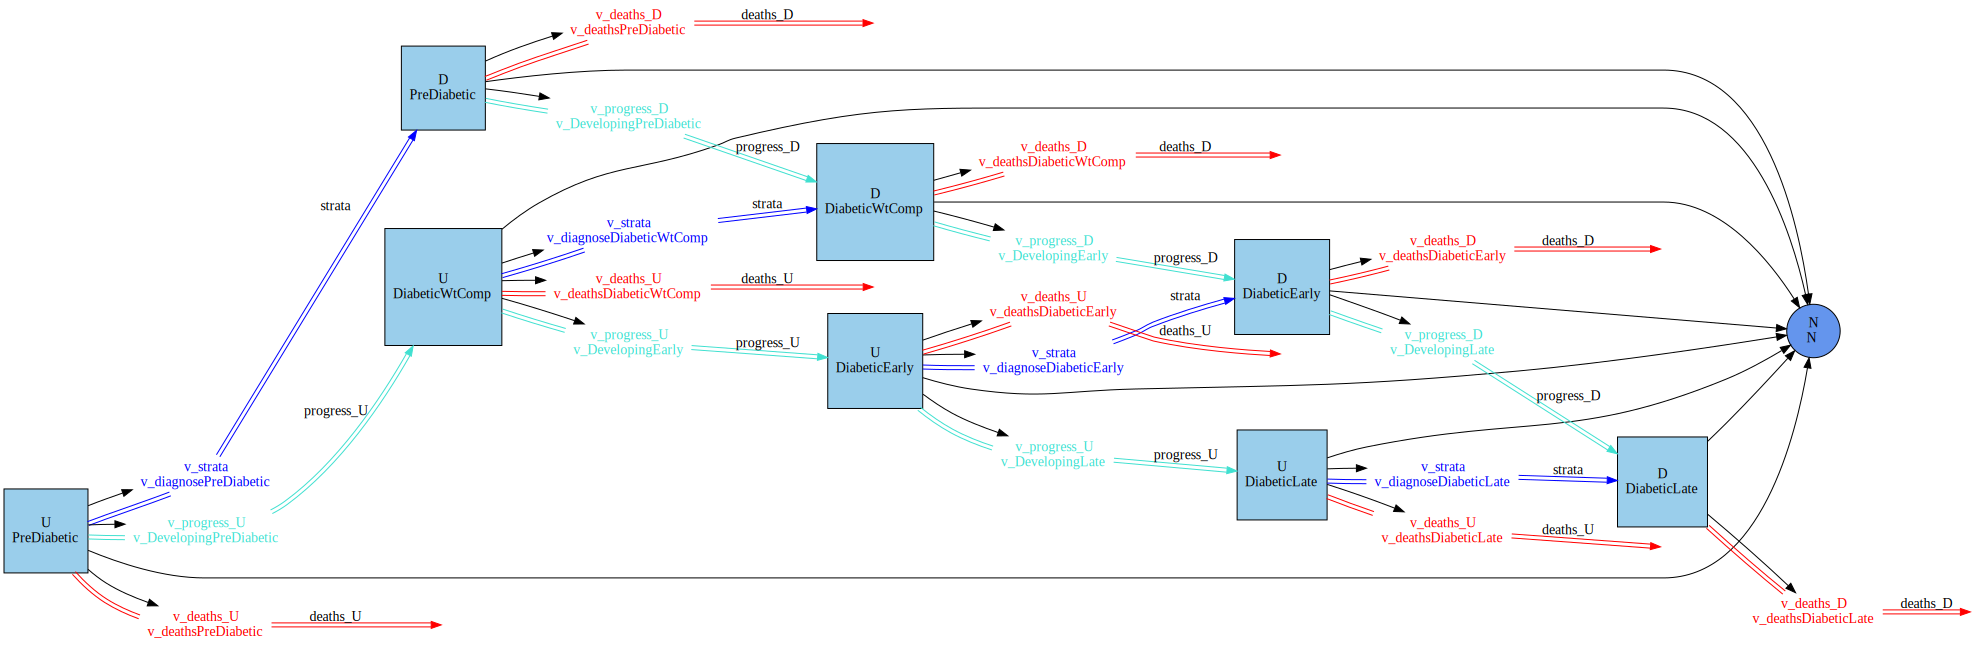

In [35]:
typed_stratified_model = typed_stratify(typed_diagnosis_strata, typed_diabetes_progress)
Graph_typed(typed_stratified_model)

In [40]:
# I think this is correct
# we need to define the functions, parameters and initial values and then run the ODEs